In [1]:
import os

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 3
# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

In [3]:
config = DotMap({
    'ds': 'mnist',
    'distributed': True,
    'minibatch_size': 8,
    'n_steps': 120001,
    'test_size': 300,
    'test_minibatch_size': 25,
    'test_interval': 500,
    'test_n_shuf': [392, 1, 64, 128, 256],
    'test_n_seq': [392, 1, 128, 256, 512],
    'test_autoregressive': False,
    'noise_fraction': 0,
    'display_images': True,
    'display_image_interval': 5000,
    'dont_display_until_loss': 0.48,
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': ['constant', 0.0004],
    'lr_warmup': 100,
    'grad_accum_steps': None, #['exponential', 1, 4],
    'max_accum_steps': 4,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 80,
    'kmeans_batch_size': 1000,
    'mixed_float': False,
    'continuous': False,
})

config.discrete = not config.continuous

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

Example integers sampled from gamma distribution.
tf.Tensor(
[149 140 324  53 371 111 100 375 225  85 456  42  38 226 135  82  11 369
  91  10 104  76 175  64 113  20 111 294  86  28  31  84  70 339  49 201
 222 228 105 321 272  43 101 412 197 369  82  68 208 361  13 151  50  37
 261 347 408 374 150 117 166  69  50  27 237 287 144  43 179  30 386  41
 108 139  60  53 286  26 110 105 164 154  72 144 175 122 135  24 775  93
  31 370   7  39 278 190  74   9 366 558], shape=(100,), dtype=int32)
Init 1/3 with method k-means++
Inertia for init 1/3: 0.8447982326401808
Init 2/3 with method k-means++
Inertia for init 2/3: 0.6975778442443431
Init 3/3 with method k-means++
Inertia for init 3/3: 0.5303959852703146
Minibatch step 1/100: mean batch inertia: 0.0009197403936053571
Minibatch step 2/100: mean batch inertia: 0.0007484282452446271, ewa inertia: 0.0007484282452446271
Minibatch step 3/100: mean batch inertia: 0.0010213445187639563, ewa inertia: 0.0010213445187639563
Minibatch step 4/100: me

Not using gradient accumulation
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


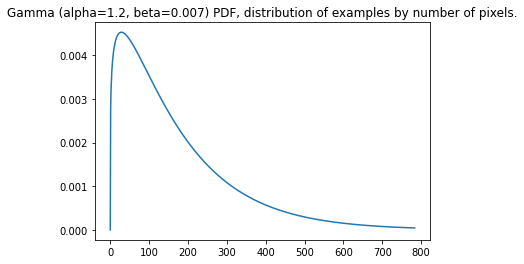

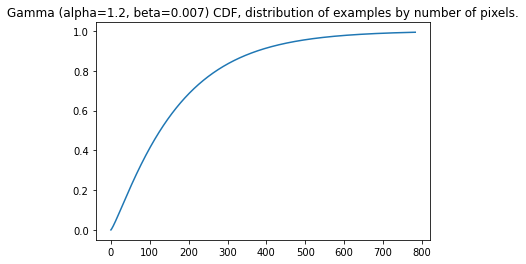

In [4]:

    
ds_configs = DotMap({
    'mnist': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'image_size': (28, 28),
    },
    'mnist_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'mnist_binary_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 2,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'celeb': {
        'name': 'celeb_a',
        'buffer_size': 10000,
        'n_colors': 16,
        'n_color_dims': 3,
        'image_size': (218, 178),
        'rescale': (32, 39),
    }
})

config.dataset = ds_configs[config.ds]
config.dataset.seq_length = config.dataset.image_size[0]*config.dataset.image_size[1]*config.dataset.n_color_dims
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
datasets.plot_distribution(config, gamma_dist, gamma_name)

dataset, metadata = tfds.load(config.dataset.name, with_info=True, as_supervised=True)

ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(config, ds_train_original)

ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)
ds_train, ds_test = ds.make_datasets()

# # model config
# config.model = DotMap({
#     'n_colors': config.dataset.n_colors,
#     'n_enc_a_layers': 3,
#     'n_enc_b_layers': 3,
#     'ffl_dim': 128,
#     'embd_dim': 512,
#     'n_dec_layers': 3,
#     'dec_dim': 600,
#     'n_heads': 4,
#     'dropout_rate': 0.1,
#     'use_idxs_input': True,
#     'architecture': 'anp',
#     'position_embedding': 'pos_enc',
#     'activation': 'swish',
# })

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     model = models.transformer(config.model)
#     # Adam params taken from the linked notebook
#     optimizer = keras.optimizers.Adam(learning_rate=config.max_lr)

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

# config.training_mode = 'combination'

# model_name = models.model_name('cuda10', config)
# model_name += "-newgamma"
# print(model_name)


In [5]:

model_name = 'models/best-tue-feb-8-standard-anp-with-bugfixes'
model = keras.models.load_model(model_name)


In [6]:
optimizer = keras.optimizers.Adam(learning_rate=schedules.learning_rate_schedule(config))
evaler = training.Evaluator(config, model, optimizer, viz, ds, ds_train_dist, ds_test)


In [7]:
def log2(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(2, dtype=numerator.dtype))
    return numerator / denominator

def entropy_of_probabilities(probabilities, do_print=False):
    if do_print:
        print("p(x) =", probabilities)
    log_probabilities = log2(probabilities)
    if do_print:
        print("log p(x) =", log_probabilities)
    entropies = -1 * tf.reduce_sum(probabilities*log_probabilities, axis=-1)
    if do_print:
        print("H(X) =", entropies)
    return entropies

def entropy_of_logits(logits, do_print=False):
    if do_print:
        print("logits =", logits)
    
    probabilities = tf.nn.softmax(logits, axis=-1)
    
    return entropy_of_probabilities(probabilities, do_print)

entropy_of_probabilities([0.5, 0.5], do_print=True)
entropy_of_logits([1., 1], do_print=True)
entropy_of_logits([4., 4], do_print=True)

entropy_of_probabilities([0.1, 0.9], do_print=True)
entropy_of_probabilities(tf.constant([[0.1, 0.9], [0.1, 0.9]]), do_print=True)
# checks out from https://machinelearningmastery.com/information-gain-and-mutual-information/




p(x) = [0.5, 0.5]
log p(x) = tf.Tensor([-1. -1.], shape=(2,), dtype=float32)
H(X) = tf.Tensor(1.0, shape=(), dtype=float32)
logits = [1.0, 1]
p(x) = tf.Tensor([0.5 0.5], shape=(2,), dtype=float32)
log p(x) = tf.Tensor([-1. -1.], shape=(2,), dtype=float32)
H(X) = tf.Tensor(1.0, shape=(), dtype=float32)
logits = [4.0, 4]
p(x) = tf.Tensor([0.5 0.5], shape=(2,), dtype=float32)
log p(x) = tf.Tensor([-1. -1.], shape=(2,), dtype=float32)
H(X) = tf.Tensor(1.0, shape=(), dtype=float32)
p(x) = [0.1, 0.9]
log p(x) = tf.Tensor([-3.321928   -0.15200314], shape=(2,), dtype=float32)
H(X) = tf.Tensor(0.46899563, shape=(), dtype=float32)
p(x) = tf.Tensor(
[[0.1 0.9]
 [0.1 0.9]], shape=(2, 2), dtype=float32)
log p(x) = tf.Tensor(
[[-3.321928   -0.15200314]
 [-3.321928   -0.15200314]], shape=(2, 2), dtype=float32)
H(X) = tf.Tensor([0.46899563 0.46899563], shape=(2,), dtype=float32)


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.46899563, 0.46899563], dtype=float32)>

In [8]:
def autoreg_sample(m, t_loop, modes=["sequential"], seed_colors=None, all_idxs=None, manager=None):
    
    if seed_colors is None:
        n = 1
        batch_size = 9
        seed_colors = tf.zeros([9, n], tf.int32)
    else:
        batch_size = seed_colors.shape[0]
        n = seed_colors.shape[1]
    if all_idxs is None:
        n_total = config.dataset.image_size[0] * config.dataset.image_size[1]
        all_idxs = tf.tile(tf.range(n_total)[None, :], [batch_size, 1])
    else:
        n_total = all_idxs.shape[1]
    assert all_idxs.shape[0] == batch_size, f"seed_colors and all_idxs must have the same batch_size dim. Got {batch_size} and {all_idxs.shape[0]}."
    seed_idxs = all_idxs[:, :n]
    tar_idxs = all_idxs[:, 1:]

    if manager is None:
        manager = enlighten.get_manager()
    
    steps_counter = manager.counter(total=len(modes) + 1, desc="Running Experiments", unit='steps', leave=False)
    
    # produce expected value visualization
    inp_idxs = all_idxs[:1, :n]
    tar_idxs = all_idxs[:1, n:]
    inp_colors = seed_colors[:1]
    logits = t_loop.eval_step(inp_colors, inp_idxs, tar_idxs)
    probabilities = tf.nn.softmax(logits, axis=2)
    expected_col = ds.expected_col(probabilities)
    
    steps_counter.update()
    
    viz.showSeq(inp_colors[:1],                all_idxs[:1, :n], config.dataset.image_size, 1,          unshuffle=True)
    viz.showSeq(expected_col,                  all_idxs[:1, n:], config.dataset.image_size, 1,          unshuffle=True, do_unquantize=False)
    
    if "sequential" in modes:
        # produce autoregressive samples in index order. Left -> Right, Top -> Bottom
        mode = "sequential"
        evaluate_counter = manager.counter(total=n_total-n, desc=f"Sampling - '{mode}' order", unit='pixels', leave=True)
        
        autoregressive_samples = seed_colors
        for i in evaluate_counter(range(n, n_total)):

            inp_idxs = all_idxs[:, :i]
            tar_idxs = all_idxs[:, i:i+1]

            logits = t_loop.eval_step(autoregressive_samples, inp_idxs, tar_idxs)

            # apply softmax on the logits and sample from the distribution
            samples = tf.random.categorical(logits[:, 0], 1, dtype=tf.int32)
            autoregressive_samples = tf.concat([autoregressive_samples, samples], axis=-1)
        
        evaluate_counter.close()
        steps_counter.update()
        
        viz.showSeq(autoregressive_samples[:, n:], all_idxs[:, n:],  config.dataset.image_size, batch_size, unshuffle=True)
        # create a colouring for the order that the pixels were sampled in
        order_coloring = tf.cast(tf.tile(tf.range(784)[None, :], [batch_size, 1]), tf.float32) / n_total
        order_coloring = order_coloring[:, :, None] # add color dim
        viz.showSeq(order_coloring, all_idxs, config.dataset.image_size, batch_size, do_unquantize=False, unshuffle=True)
    
    if "sequential_argmax" in modes:
        # produce autoregressive samples in index order. Left -> Right, Top -> Bottom
        mode = "sequential"
        evaluate_counter = manager.counter(total=n_total-n, desc=f"Sampling - '{mode}' order", unit='pixels', leave=True)
        
        autoregressive_samples = seed_colors
        for i in evaluate_counter(range(n, n_total)):

            inp_idxs = all_idxs[:, :i]
            tar_idxs = all_idxs[:, i:i+1]

            logits = t_loop.eval_step(autoregressive_samples, inp_idxs, tar_idxs)

            # apply softmax on the logits and sample from the distribution
            samples = tf.argmax(logits[:, 0])
            autoregressive_samples = tf.concat([autoregressive_samples, samples], axis=-1)
        
        evaluate_counter.close()
        steps_counter.update()
        
        viz.showSeq(autoregressive_samples[:, n:], all_idxs[:, n:],  config.dataset.image_size, batch_size, unshuffle=True)
        # create a colouring for the order that the pixels were sampled in
        order_coloring = tf.cast(tf.tile(tf.range(784)[None, :], [batch_size, 1]), tf.float32) / n_total
        order_coloring = order_coloring[:, :, None] # add color dim
        viz.showSeq(order_coloring, all_idxs, config.dataset.image_size, batch_size, do_unquantize=False, unshuffle=True)
    
    if "random" in modes:
        # produce autoregressive samples in random order
        mode = "random"
        evaluate_counter = manager.counter(total=n_total-n, desc=f"Sampling - '{mode}' order", unit='pixels', leave=True)
        
        # the [n:] is so we don't shuffle the seed pixels
        shuf_idxs = [tf.random.shuffle(all_idxs[i, n:])[None, :] for i in range(batch_size)]
        shuf_idxs = tf.concat(shuf_idxs, axis=0)
        shuf_idxs = tf.concat([seed_idxs, shuf_idxs], axis=-1)
        
        autoregressive_samples = seed_colors
        for i in evaluate_counter(range(n, n_total)):
            
            inp_idxs = shuf_idxs[:, :i]
            tar_idxs = shuf_idxs[:, i:i+1]

            logits = t_loop.eval_step(autoregressive_samples, inp_idxs, tar_idxs)

            # apply softmax on the logits and sample from the distribution
            samples = tf.random.categorical(logits[:, 0], 1, dtype=tf.int32)
            samples = tf.concat(samples, axis=0)
            autoregressive_samples = tf.concat([autoregressive_samples, samples], axis=-1)

        evaluate_counter.close()
        steps_counter.update()
    
        viz.showSeq(autoregressive_samples[:, n:], shuf_idxs[:, n:],  config.dataset.image_size, batch_size, unshuffle=True)
        # create a colouring for the order that the pixels were sampled in
        order_coloring = tf.cast(tf.tile(tf.range(784)[None, :], [batch_size, 1]), tf.float32) / n_total
        order_coloring = order_coloring[:, :, None] # add color dim
        viz.showSeq(order_coloring, shuf_idxs, config.dataset.image_size, batch_size, do_unquantize=False, unshuffle=True)

    
    if "highest_entropy" in modes:
        # produce autoregressive samples in order of the highest entropy sample next
        mode = "highest_entropy"
        evaluate_counter = manager.counter(total=n_total-n, desc=f"Sampling - '{mode}' order", unit='pixels', leave=True)
        
        used_idxs = seed_idxs
        unused_idxs = all_idxs[:, n:]
        
        autoregressive_samples = seed_colors
        for i in evaluate_counter(range(n, n_total)):
            
            inp_idxs = used_idxs
            tar_idxs = unused_idxs

            logits = t_loop.eval_step(autoregressive_samples, inp_idxs, tar_idxs)
            
            entropies = entropy_of_logits(logits)
            
            sample_idxs = tf.cast(tf.math.argmax(entropies, axis=-1), tf.int32)
            sample_idxs_nd = tf.stack([tf.range(batch_size), sample_idxs], axis=-1)
            
            logit_distributions = tf.gather_nd(logits, sample_idxs_nd)
            this_used_idxs = tf.gather_nd(tar_idxs, sample_idxs_nd)
            
            # apply softmax on the logits and sample from the distribution
            samples = tf.random.categorical(logit_distributions, 1, dtype=tf.int32)
            autoregressive_samples = tf.concat([autoregressive_samples, samples], axis=-1)
            used_idxs = tf.concat([used_idxs, this_used_idxs[:, None]], axis=-1)
            unused_idxs = tf.sparse.to_dense(tf.sets.difference(all_idxs, used_idxs))

        evaluate_counter.close()
        steps_counter.update()
        
        viz.showSeq(autoregressive_samples[:, n:], used_idxs[:, n:],  config.dataset.image_size, batch_size, unshuffle=True)
        # create a colouring for the order that the pixels were sampled in
        order_coloring = tf.cast(tf.tile(tf.range(784)[None, :], [batch_size, 1]), tf.float32) / n_total
        order_coloring = order_coloring[:, :, None] # add color dim
        viz.showSeq(order_coloring, used_idxs, config.dataset.image_size, batch_size, do_unquantize=False, unshuffle=True)
    
    if "lowest_entropy" in modes:
        # produce autoregressive samples in order of the highest entropy sample next
        mode = "lowest_entropy"
        evaluate_counter = manager.counter(total=n_total-n, desc=f"Sampling - '{mode}' order", unit='pixels', leave=True)
        
        used_idxs = seed_idxs
        unused_idxs = all_idxs[:, n:]
                    
        entropies = entropy_of_logits(logits)
        
        autoregressive_samples = seed_colors
        for i in evaluate_counter(range(n, n_total)):
            
            inp_idxs = used_idxs
            tar_idxs = unused_idxs

            logits = t_loop.eval_step(autoregressive_samples, inp_idxs, tar_idxs)
            
            entropies = entropy_of_logits(logits)
            
            sample_idxs = tf.cast(tf.math.argmin(entropies, axis=-1), tf.int32)
            sample_idxs_nd = tf.stack([tf.range(batch_size), sample_idxs], axis=-1)
            
            logit_distributions = tf.gather_nd(logits, sample_idxs_nd)
            this_used_idxs = tf.gather_nd(tar_idxs, sample_idxs_nd)
            
            # apply softmax on the logits and sample from the distribution
            samples = tf.random.categorical(logit_distributions, 1, dtype=tf.int32)
            autoregressive_samples = tf.concat([autoregressive_samples, samples], axis=-1)
            used_idxs = tf.concat([used_idxs, this_used_idxs[:, None]], axis=-1)
            unused_idxs = tf.sparse.to_dense(tf.sets.difference(all_idxs, used_idxs))

        evaluate_counter.close()
        steps_counter.update()
    
        viz.showSeq(autoregressive_samples[:, n:], used_idxs[:, n:],  config.dataset.image_size, batch_size, unshuffle=True)
        # create a colouring for the order that the pixels were sampled in
        order_coloring = tf.cast(tf.tile(tf.range(784)[None, :], [batch_size, 1]), tf.float32) / n_total
        order_coloring = order_coloring[:, :, None] # add color dim
        viz.showSeq(order_coloring, used_idxs, config.dataset.image_size, batch_size, do_unquantize=False, unshuffle=True)



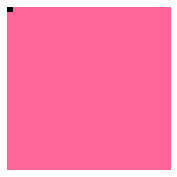

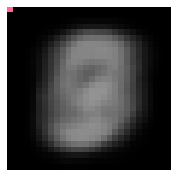

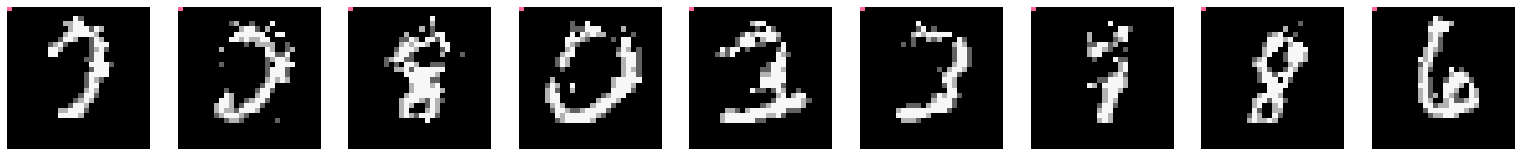

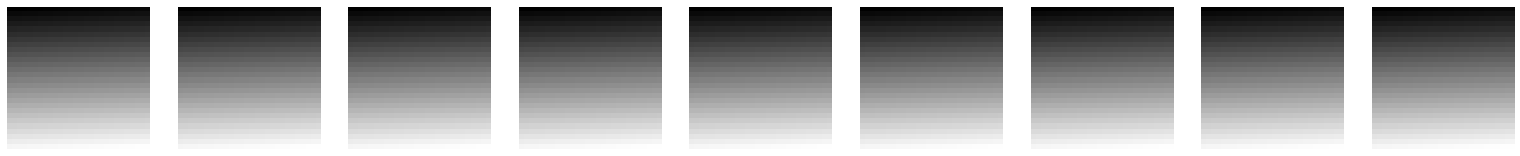

InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a int32 tensor but is a int64 tensor [Op:ConcatV2] name: concat

In [9]:

autoreg_sample(model, evaler, {"sequential", "sequential_argmax", "random", "highest_entropy", "lowest_entropy"})

In [ ]:
all_colors = training_loop.test_colors
all_idxs = training_loop.test_idxs
batch_size = all_colors.shape[0]
n = all_colors.shape[-1] // 2
half_colors = all_colors[:, :n]
half_idxs = all_idxs[:, :n]
autoreg_sample(model, training_loop, {"sequential", "random", "highest_entropy", "lowest_entropy"}, seed_colors=half_colors, )

In [ ]:
training_loop.process_batch()

In [ ]:
entropies = tf.constant([[0.1, 0.3], [0.3, 0.2], [0.2, 0.2]])
sample_idxs = tf.cast(tf.math.argmax(entropies, axis=-1), tf.int32)
sample_idxs_nd = tf.stack([tf.range(entropies.shape[0]), sample_idxs], axis=-1)
print(sample_idxs_nd)

logits = tf.constant([[[1, 3, 4], [2, 2, 2]], [[5, 5, 5], [5, 5, 4]], [[1, 4, 3], [3, 4, 1]]])

dists = tf.gather_nd(logits, sample_idxs_nd)
print(dists)

In [ ]:
x = tf.sets.difference(tf.concat([tf.range(10)[None, :], (tf.range(10) + 3)[None, :]], axis=0), tf.constant([[1, 2, 3], [6, 7, 8]], dtype=tf.int32))
tf.sparse.to_dense(x)